In [1]:
! pip install neptune-client
! pip install torchmetrics
! pip install fvcore simplejson timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 321 kB 14.9 MB/s 
     |████████████████████████████████| 829 kB 51.8 MB/s 
     |████████████████████████████████| 54 kB 2.7 MB/s 
     |████████████████████████████████| 181 kB 55.2 MB/s 
     |████████████████████████████████| 132 kB 56.3 MB/s 
     |████████████████████████████████| 56 kB 4.0 MB/s 
     |████████████████████████████████| 9.1 MB 40.1 MB/s 
     |████████████████████████████████| 79 kB 4.5 MB/s 
     |████████████████████████████████| 140 kB 43.6 MB/s 
     |████████████████████████████████| 63 kB 1.5 MB/s 
     |████████████████████████████████| 127 kB 50.6 MB/s 
     |████████████████████████████████| 130 kB 45.0 MB/s 
     |████████████████████████████████| 67 kB 4.7 MB/s 
     |████████████████████████████████| 82 kB 960 kB/s 
     |████████████████████████████████| 82 kB 678 kB/s 
     |████████████████████████████████| 81 kB



1.   Go to https://drive.google.com/drive/folders/1j5jrtQ2zIuSRyIPni2tVmyU1SEB-VORz?usp=sharing
2.   Make a copy of major.zip
3.   Move the copy to your own drive
4.   Rename the copy back to major.zip
5.   Change the `unzip` path from `/content/drive/MyDrive/VIP/major.zip` to the saved location.



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip "/content/drive/MyDrive/VIP Cup/Major/major.zip"

Streaming output truncated to the last 5000 lines.
  inflating: Major/data/Taming_class_423_000929.png  
  inflating: Major/data/gated_inpainting_id000000065855.png  
  inflating: Major/data/stylegan3_ffhq-r_seed0954.png  
  inflating: Major/data/000000035498.jpg  
  inflating: Major/data/glide_text2img_annot000000138934.png  
  inflating: Major/data/gated_inpainting_id000000018476.png  
  inflating: Major/data/Taming_ffhq_036014.png  
  inflating: Major/data/realffhq_25162.png  
  inflating: Major/data/000000060641.jpg  
  inflating: Major/data/glide_text2img_annot000000088143.png  
  inflating: Major/data/Taming_coco_samples_4865_samples_nopix_003298.png  
  inflating: Major/data/gated_inpainting_id000000067634.png  
  inflating: Major/data/glide_text2img_annot000000031458.png  
  inflating: Major/data/stylegan2_horse_stylegan2-config-f-psi-10_042597.png  
  inflating: Major/data/000000437145.jpg  
  inflating: Major/data/000000296848.jpg  
  inflating: Major/data/stylegan3_afhq-r_se

In [4]:
import os
import random
from PIL import Image
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt 

import albumentations as A
import torch
from torch.utils.data import Dataset, DataLoader
from albumentations.pytorch.transforms import ToTensorV2
from albumentations import RandomCrop, RandomResizedCrop

In [5]:
with open("Major/train.txt","r+") as f0:
  train_list = f0.read().split("\n")

with open("Major/val.txt","r+") as f0:
  val_list = f0.read().split("\n")

with open("Major/test.txt","r+") as f0:
  test_list = f0.read().split("\n")

labels = pd.read_csv("Major/labels.csv")

In [6]:
labels.head()

,image_ids,label,image_path,dataset_identifier
0,glide_inpainting_id000000295286.png,1,/content/drive/MyDrive/VIP Cup/Major/aug_data/...,glide inpainting
1,glide_inpainting_id000000131531.png,1,/content/drive/MyDrive/VIP Cup/Major/aug_data/...,glide inpainting
2,glide_text2img_annot000000037817.png,1,/content/drive/MyDrive/VIP Cup/Major/aug_data/...,glide text2img
3,glide_text2img_annot000000062141.png,1,/content/drive/MyDrive/VIP Cup/Major/aug_data/...,glide text2img
4,glide_text2img_annot000000062715.png,1,/content/drive/MyDrive/VIP Cup/Major/aug_data/...,glide text2img


In [7]:
tags = labels['dataset_identifier'].unique()
h2l_dict = dict([(t,t.split(' ')[0]) if len(t.split(' '))>1 else (t,t) for t in tags])
h2l_dict

{'glide inpainting': 'glide',
 'glide text2img': 'glide',
 'gated inpainting': 'gated',
 'Taming class': 'Taming',
 'Taming coco': 'Taming',
 'Taming ffhq': 'Taming',
 'stylegan3 ffhqu-t': 'stylegan3',
 'stylegan3 meltfaces-t': 'stylegan3',
 'stylegan3 meltfacesu-t': 'stylegan3',
 'stylegan3 ffhqu-r': 'stylegan3',
 'stylegan3 meltfaces-r': 'stylegan3',
 'stylegan3 meltfacesu-r': 'stylegan3',
 'stylegan3 afhq-t': 'stylegan3',
 'stylegan3 ffhq-t': 'stylegan3',
 'stylegan2 car': 'stylegan2',
 'stylegan2 ffhq': 'stylegan2',
 'stylegan3 afhq-r': 'stylegan3',
 'stylegan3 ffhq-r': 'stylegan3',
 'stylegan2 cat': 'stylegan2',
 'stylegan2 church': 'stylegan2',
 'stylegan2 horse': 'stylegan2',
 'coco_standard': 'coco_standard',
 'realffhq': 'realffhq'}

In [8]:
labels['tag'] = labels['dataset_identifier'].map(h2l_dict)
tags = labels['tag'].unique()
tag_dict = dict(zip(tags, range(len(tags))))
tag_dict

{'glide': 0,
 'gated': 1,
 'Taming': 2,
 'stylegan3': 3,
 'stylegan2': 4,
 'coco_standard': 5,
 'realffhq': 6}

In [9]:
labels['tag_ind'] = labels['tag'].map(tag_dict)
labels.head()

,image_ids,label,image_path,dataset_identifier,tag,tag_ind
0,glide_inpainting_id000000295286.png,1,/content/drive/MyDrive/VIP Cup/Major/aug_data/...,glide inpainting,glide,0
1,glide_inpainting_id000000131531.png,1,/content/drive/MyDrive/VIP Cup/Major/aug_data/...,glide inpainting,glide,0
2,glide_text2img_annot000000037817.png,1,/content/drive/MyDrive/VIP Cup/Major/aug_data/...,glide text2img,glide,0
3,glide_text2img_annot000000062141.png,1,/content/drive/MyDrive/VIP Cup/Major/aug_data/...,glide text2img,glide,0
4,glide_text2img_annot000000062715.png,1,/content/drive/MyDrive/VIP Cup/Major/aug_data/...,glide text2img,glide,0


In [10]:
import yaml

# Change yaml file path as reqiuired
with open('/content/drive/MyDrive/VIP/M2TR/configs/colab.yaml', 'r') as file:
    cfg = yaml.safe_load(file)

In [11]:
def construct_dataloder(dataset, batch_size, shuffle=True):
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

class VIPDataset(Dataset):
    def __init__(self, df, data_dir):
      self.df = df
      self.file_ids = df['image_ids'].values
      self.labels = df['tag'].values
      self.ys = df['tag_ind'].values
      self.data_dir = data_dir
      size = cfg['MODEL']['IMG_SIZE']
      self.distortion_pipeline = A.Compose([
                    # A.CLAHE(p=0.2),
                    A.RandomRotate90(p=0.2),
                    #A.Transpose(p=0.2),
                    A.Flip(p=0.5),
                    A.HorizontalFlip(p=0.5),
                    # A.Blur(blur_limit=3,p=0.2),
                    #A.OpticalDistortion(p=0.2),
                    #A.GridDistortion(p=0.2),
                    # A.HueSaturationValue(p=0.2)
                    ])
      
      self.aug = A.Compose([
          #A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.50, rotate_limit=45, p=1),
          # A.augmentations.geometric.resize.RandomScale(scale_limit=[0,2],interpolation=cv.INTER_CUBIC,p=0.3),
          A.augmentations.crops.transforms.RandomResizedCrop(size,size,scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=cv.INTER_CUBIC,p=0.5),
      ])
      self.end_transform = A.Compose([A.augmentations.geometric.resize.Resize (size, size, interpolation=cv.INTER_CUBIC, p=1),
                                      A.augmentations.transforms.ImageCompression(quality_lower=65, quality_upper=100, always_apply=True, p=1), 
                                      ToTensorV2()])

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        image_id = self.file_ids[index]
        img = Image.open(os.path.join(self.data_dir, image_id))
        label = self.labels[index]
        y = self.ys[index]

        x = np.array(img)
        x = self.distortion_pipeline(image=x)['image']

        if label not in ["glide","gated"]:
          x = self.aug(image=x)['image']
        
        x = self.end_transform(image=x)['image']
        return x, torch.nn.functional.one_hot(torch.tensor([y]).squeeze(), num_classes=7)


In [12]:
train_df = labels.loc[labels['image_ids'].isin(train_list), :]
val_df = labels.loc[labels['image_ids'].isin(val_list), :]
test_df = labels.loc[labels['image_ids'].isin(test_list), :]

train_ds = VIPDataset(train_df,"Major/data")
val_ds = VIPDataset(val_df,"Major/data")
test_ds = VIPDataset(test_df,"Major/data")

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=32, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=32, shuffle=False)

In [13]:
for _ in train_dl:
  pass

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'PngImageFile'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)


IndexError: ignored

6643 torch.Size([3, 192, 192]) torch.Size([7])
tensor([0, 0, 0, 0, 1, 0, 0])
11555 torch.Size([3, 192, 192]) torch.Size([7])
tensor([0, 0, 0, 0, 0, 1, 0])
5578 torch.Size([3, 192, 192]) torch.Size([7])
tensor([0, 0, 0, 1, 0, 0, 0])
3660 torch.Size([3, 192, 192]) torch.Size([7])
tensor([0, 0, 1, 0, 0, 0, 0])


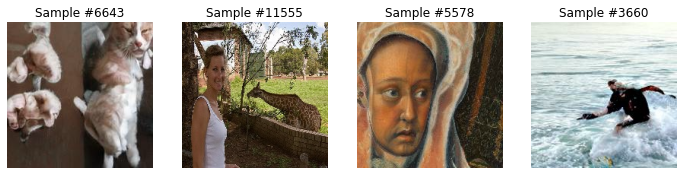

In [14]:
plt.figure(figsize=(12,4))
for j, i in enumerate(random.sample(set(range(len(train_ds))), 4)):
    sample_image, sample_label = train_ds[i]
    print(i, sample_image.shape, sample_label.shape)

    ax = plt.subplot(1, 4, j + 1)
#     plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    ax.imshow(np.transpose(sample_image, (1, 2, 0)))
    print(sample_label)
    if i == 3:
        plt.show()
        break

In [15]:
! git clone https://github.com/wangjk666/M2TR-Multi-modal-Multi-scale-Transformers-for-Deepfake-Detection.git
! cp -r /content/M2TR-Multi-modal-Multi-scale-Transformers-for-Deepfake-Detection/* .

Cloning into 'M2TR-Multi-modal-Multi-scale-Transformers-for-Deepfake-Detection'...
remote: Enumerating objects: 119, done.
remote: Counting objects: 100% (119/119), done.
remote: Compressing objects: 100% (84/84), done.
remote: Total 119 (delta 52), reused 79 (delta 31), pack-reused 0
Receiving objects: 100% (119/119), 1.80 MiB | 9.78 MiB/s, done.
Resolving deltas: 100% (52/52), done.


In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [17]:
from torchmetrics import Recall, Precision, F1Score, Accuracy
metrics = {
    'accuracy': Accuracy(num_classes=7, average='macro').to(device),
    'recall': Recall(num_classes=7, average='macro').to(device),
    'precision': Precision(num_classes=7, average='macro').to(device),
    'f1_score': F1Score(num_classes=7, average='macro').to(device)
}

In [19]:
import neptune.new as neptune
run = neptune.init(
    project="Botz/VIPCup-logs",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJkNWJjMDdhNC05NWY5LTQwNWQtYTQyNi0zNjNmYmYwZDg3M2YifQ==",
)

https://app.neptune.ai/Botz/VIPCup-logs/e/VIP-76
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [20]:
run = {}
params = {
    "Model-Name": cfg['MODEL']['MODEL_NAME'],
    'Dataset-Name': cfg['DATASET']['DATASET_NAME'],
    "dl-version": 'v3',
    "max_epochs": cfg['TRAIN']['MAX_EPOCH'],
}
run["parameters"] = params

In [21]:
import pprint

import numpy as np
import torch
from torch.utils.tensorboard import SummaryWriter

import M2TR.utils.checkpoint as cu
import M2TR.utils.distributed as du
import M2TR.utils.logging as logging
from M2TR.utils.build_helper import (
    build_dataloader,
    build_dataset,
    build_loss_fun,
    build_model,
)
from M2TR.utils.meters import EpochTimer, MetricLogger, SmoothedValue
from M2TR.utils.optimizer import build_optimizer
from M2TR.utils.scheduler import build_scheduler
from tools.test import perform_test

import tqdm.notebook as tq

logger = logging.get_logger(__name__)


@torch.no_grad()
def perform_test(
    test_loader, model, cfg, cur_epoch=None, writer=None, mode='Test'
):
    criterion = build_loss_fun(cfg)

    record_list = list(metrics.keys())
    recorder = {metric: [] for metric in record_list}

    model.eval()

    for imgs, labels in tq.tqdm(test_loader):
        imgs = imgs.to(device).float()
        labels = labels.to(device).float()
        
        samples = {'img': imgs, 'bin_label_onehot': labels}

        with torch.cuda.amp.autocast(enabled=cfg['AMP_ENABLE']):
            outputs = model(samples)
            loss = criterion(outputs, samples)

        
        for i in record_list:
            preds = torch.argmax(outputs['logits'], dim=1)
            labels = torch.argmax(samples['bin_label_onehot'], dim=1)
            recorder[i].append(metrics[i](preds, labels))

    for i in record_list:
        metric = sum(recorder[i])/len(recorder[i])
        recorder[i] = metric
        print(f'{i}: {metric}')
        run[f'val/{i}'].log(metric)
    
    return recorder


def train_epoch(
    train_loader, model, criterion, optimizer, cfg, cur_epoch, cur_iter, writer
):
    model.train()
    header = 'Epoch: [{}]'.format(cur_epoch)
    print_freq = 10

    record_list = list(metrics.keys())
    recorder = {metric: [] for metric in record_list}

    for imgs, labels in tq.tqdm(train_loader):
        imgs = imgs.to(device).float()
        labels = labels.to(device).float()
        
        samples = {'img': imgs, 'bin_label_onehot': labels}

        with torch.cuda.amp.autocast(enabled=cfg['AMP_ENABLE']):
            outputs = model(samples)
            loss = criterion(outputs, samples)

        
        for i in record_list:
            preds = torch.argmax(outputs['logits'], dim=1)
            labels = torch.argmax(samples['bin_label_onehot'], dim=1)
            recorder[i].append(metrics[i](preds, labels))

        loss_value = loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        torch.cuda.synchronize()

        if 'CLIP_GRAD_L2NORM' in cfg['TRAIN']:  # TODO
            torch.nn.utils.clip_grad_norm_(
                model.parameters(), cfg['TRAIN']['CLIP_GRAD_L2NORM']
            )

        if writer:
            writer.add_scalar('train loss', loss_value, global_step=cur_iter)
            writer.add_scalar(
                'lr', optimizer.param_groups[0]["lr"], global_step=cur_iter
            )
        cur_iter = cur_iter + 1

    for i in record_list:
        metric = sum(recorder[i])/len(recorder[i])
        print(f'{i}: {metric}')
        run[f'train/{i}'].log(metric)

    return {}, cur_iter


def train(
    train_loader, val_loader, cfg
):
    np.random.seed(cfg['RNG_SEED'])
    torch.manual_seed(cfg['RNG_SEED'])

    if du.is_master_proc(du.get_world_size()):
        writer = SummaryWriter(cfg['LOG_FILE_PATH'])
    else:
        writer = None

    best_model = model = build_model(cfg)
    optimizer = build_optimizer(model.parameters(), cfg)
    scheduler, _ = build_scheduler(optimizer, cfg)  # TODO _?
    loss_fun = build_loss_fun(cfg)

    start_epoch = cu.load_train_checkpoint(model, optimizer, scheduler, cfg)

    logger.info("Start epoch: {}".format(start_epoch + 1))
    epoch_timer = EpochTimer()

    cur_iter = 0
    best_acc = 0

    for cur_epoch in range(start_epoch, cfg['TRAIN']['MAX_EPOCH']):
        print('========================================================')
        epoch_timer.epoch_tic()
        _, cur_iter = train_epoch(
            train_loader,
            model,
            loss_fun,
            optimizer,
            cfg,
            cur_epoch,
            cur_iter,
            writer,
        )
        epoch_timer.epoch_toc()
        recorder = perform_test(val_loader, model, cfg, cur_epoch, writer, mode='Val')
        
        if recorder['accuracy'] > best_acc:
            best_acc = recorder['accuracy']
            best_model = model
        
        print(
            f"Epoch {cur_epoch} takes {epoch_timer.last_epoch_time():.2f}s. Epochs "
            f"from {start_epoch} to {cur_epoch} take "
            f"{epoch_timer.avg_epoch_time():.2f}s in average and "
            f"{epoch_timer.median_epoch_time():.2f}s in median."
        )
        print(
            f"For epoch {cur_epoch}, each iteraction takes "
            f"{epoch_timer.last_epoch_time()/len(train_loader):.2f}s in average. "
            f"From epoch {start_epoch} to {cur_epoch}, each iteraction takes "
            f"{epoch_timer.avg_epoch_time()/len(train_loader):.2f}s in average."
        )

        scheduler.step(cur_epoch)

        is_checkp_epoch = cu.is_checkpoint_epoch(cfg, cur_epoch)

        if is_checkp_epoch:
            cu.save_checkpoint(model, optimizer, scheduler, cur_epoch, cfg)

    if writer:
        writer.flush()
        writer.close()
    
    return best_model

In [ ]:
import logging
loggers = [logging.getLogger(name) for name in logging.root.manager.loggerDict]
for logger in loggers:
  logger.setLevel(logging.CRITICAL)

model_ft = train(
    train_dl,
    val_dl,
    cfg=cfg,
)

Loaded pretrained weights for efficientnet-b4


  0%|          | 0/489 [00:00<?, ?it/s]

In [ ]:
# Change model save path to the preferred save location
model_num = 54 # Adjust based on netune run number
model_name = f"/content/drive/MyDrive/VIP/model_{model_num}.pt"
torch.save(model_ft, model_name)
print(model_name)

In [ ]:
run.stop()

# Test

In [ ]:
# Define model path if not defined already
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = torch.load(model_name).to(device)

In [ ]:
import torch
import pandas as pd
from tqdm import tqdm

In [ ]:
def construct_dataloder(dataset, batch_size, shuffle=True, num_workers=4):
    return DataLoader(dataset, batch_size=batch_size,
                      shuffle=shuffle, num_workers=num_workers)

class VIPDataset(Dataset):
    def __init__(self, file_ids, labels, data_dir,):
        self.file_ids = file_ids
        self.labels = labels
        self.data_dir = data_dir
        size = cfg['MODEL']['IMG_SIZE']
        self.aug = transform = A.Compose([
            A.augmentations.geometric.resize.RandomScale(scale_limit=[0,2],interpolation=cv.INTER_LINEAR,p=0.3),
            A.augmentations.transforms.ImageCompression(quality_lower=99, quality_upper=100, always_apply=False, p=0.3),
            A.augmentations.geometric.resize.SmallestMaxSize(max_size=int(size * 1.2)),
            # A.augmentations.crops.transforms.RandomCrop(width=200, height=200,p=1)
        ])
        self.trans = A.Compose([RandomCrop(width=size, height=size, p=1), ToTensorV2()])

    def __len__(self):
        return len(self.file_ids)

    def __getitem__(self, index):
        image_id = self.file_ids[index]
        x = np.array(Image.open(os.path.join(self.data_dir, image_id)))
        x = self.aug(image=x)['image']
        x = self.trans(image=x)['image']
        y = int(self.labels.loc[self.labels["image_ids"] == image_id,"label"])
        return x, torch.nn.functional.one_hot(torch.from_numpy(np.array(y)), 2), image_id

    def augment(self, x):
        """Augmentations for images"""
        return self.aug_pipeline(image=x)["image"]

In [ ]:
test_ds = VIPDataset(test_list,labels,"Major/data")
test_dl = construct_dataloder(test_ds, 8, shuffle=True, num_workers=2)

In [ ]:
use_softmax = False
accuracies = []
result_pd = pd.DataFrame([], columns=['filename', 'logit', 'label'])
for imgs, labels, filenames in tqdm(test_dl):
  imgs = imgs.to(device).float()
  labels = labels.to(device).float()
  outputs = model({'img': imgs, 'bin_label_onehot': labels})
  preds = torch.argmax(outputs['logits'], dim=1)
  labels = torch.argmax(labels, dim=1)
  new_pd = pd.DataFrame({'filename': filenames, 'logit': preds.cpu(), 'label': labels.cpu()})
  result_pd = pd.concat([result_pd, new_pd])
  
  accuracy = metrics['accuracy'](preds, labels.to(device))
  accuracies.append(accuracy)

print(f"Accuracy: {sum(accuracies)/len(accuracies)}")


In [ ]:
result_pd.head()

In [ ]:
result_pd.label = result_pd.label.astype(int)

In [ ]:
result_pd.to_csv('result.csv', index=False)

In [ ]:
correct = result_pd.logit == result_pd.label

In [ ]:
correct

In [ ]:
sum(correct) / len(correct)